In [12]:
cd /kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge


In [13]:
import tarfile
tar=tarfile.open('fer2013.tar.gz', 'r:gz')
tar.extractall('/kaggle/working')
tar.close()


In [14]:
cd /kaggle/working/fer2013

/kaggle/working/fer2013


In [15]:
import pandas as pd
df=pd.read_csv('fer2013.csv')
print(df)

#emotion categories
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [34]:
import numpy as np
train_samples = df[df['Usage']=="Training"]
validation_samples = df[df["Usage"]=="PublicTest"]
test_samples = df[df["Usage"]=="PrivateTest"]

out=df.emotion.astype(np.int32).values

df=df[:35338]
out=out[:35338]
sample=df[35885:35886]
inp=np.array([ np.fromstring(image, np.uint8, sep=" ").reshape((48, 48)) for image in df.pixels])
inp=inp[:35338]

[[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [18]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [19]:
#Achieved training_accuracy=93.85%
with tpu_strategy.scope():
        model=Sequential()
        
        #Convolution Layers
        #1
        model.add(layers.Conv2D(64, (5, 5), input_shape=(48, 48, 1), strides=1, activation=layers.LeakyReLU(alpha=0.3), kernel_regularizer=regularizers.l2(0.02)))
        model.add(layers.Conv2D(64, (5, 5), strides=1, activation=layers.LeakyReLU(alpha=0.3)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.2))
        
        #2
        model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(layers.Dropout(0.4))
        
        #3
        model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(layers.Dropout(0.4))
        
        #4
        model.add(layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.2))
        
        #5
        model.add(layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.3))
        
        
        #Fully Connected Layers
        #5 
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dropout(0.35))
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.35))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(7, activation='softmax'))
        
        model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])     



In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 128)      

In [133]:
inp = inp.reshape((-1, 48, 48, 1)).astype(np.float32)
    
inp_std=inp/255.

(1, 48, 48, 1)


FOLD: 1
TRAIN: [ 3534  3535  3536 ... 35335 35336 35337] TEST: [   0    1    2 ... 3531 3532 3533]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 21s 664us/sample - loss: 1.9373 - accuracy: 0.2233 - val_loss: 1.8429 - val_accuracy: 0.2518
Epoch 2/12
31800/31800 [==============================] - 5s 167us/sample - loss: 1.8202 - accuracy: 0.2525 - val_loss: 1.8922 - val_accuracy: 0.2518
Epoch 3/12
31800/31800 [==============================] - 5s 170us/sample - loss: 1.7199 - accuracy: 0.3043 - val_loss: 1.6620 - val_accuracy: 0.3653
Epoch 4/12
31800/31800 [==============================] - 5s 170us/sample - loss: 1.6148 - accuracy: 0.3662 - val_loss: 1.5712 - val_accuracy: 0.3679
Epoch 5/12
31800/31800 [==============================] - 5s 171us/sample - loss: 1.5454 - accuracy: 0.3947 - val_loss: 1.6398 - val_accuracy: 0.3642
Epoch 6/12
31800/31800 [==============================] - 5s 173us/sample - loss: 1.4861 - accuracy: 

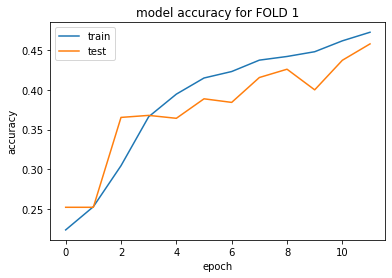


FOLD: 2
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [3534 3535 3536 ... 7065 7066 7067]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 10s 312us/sample - loss: 1.3163 - accuracy: 0.4843 - val_loss: 1.3368 - val_accuracy: 0.4734
Epoch 2/12
31800/31800 [==============================] - 5s 164us/sample - loss: 1.2904 - accuracy: 0.4955 - val_loss: 1.4580 - val_accuracy: 0.4027
Epoch 3/12
31800/31800 [==============================] - 5s 169us/sample - loss: 1.2735 - accuracy: 0.5100 - val_loss: 1.2647 - val_accuracy: 0.5300
Epoch 4/12
31800/31800 [==============================] - 5s 172us/sample - loss: 1.2439 - accuracy: 0.5234 - val_loss: 1.2997 - val_accuracy: 0.5091
Epoch 5/12
31800/31800 [==============================] - 5s 168us/sample - loss: 1.2055 - accuracy: 0.5402 - val_loss: 1.2265 - val_accuracy: 0.5249
Epoch 6/12
31800/31800 [==============================] - 5s 166us/sample - loss: 1.1991 - accuracy:

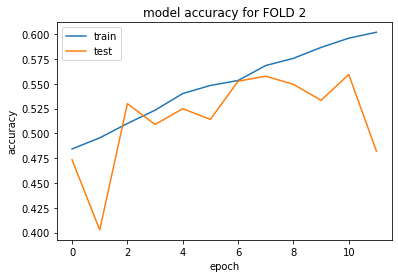


FOLD: 3
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [ 7068  7069  7070 ... 10599 10600 10601]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 10s 324us/sample - loss: 1.0783 - accuracy: 0.6102 - val_loss: 1.0324 - val_accuracy: 0.6254
Epoch 2/12
31800/31800 [==============================] - 5s 162us/sample - loss: 1.0515 - accuracy: 0.6183 - val_loss: 1.0197 - val_accuracy: 0.6200
Epoch 3/12
31800/31800 [==============================] - 5s 169us/sample - loss: 1.0286 - accuracy: 0.6318 - val_loss: 1.0425 - val_accuracy: 0.6169
Epoch 4/12
31800/31800 [==============================] - 5s 168us/sample - loss: 1.0093 - accuracy: 0.6324 - val_loss: 1.1752 - val_accuracy: 0.5690
Epoch 5/12
31800/31800 [==============================] - 5s 168us/sample - loss: 0.9880 - accuracy: 0.6488 - val_loss: 1.0943 - val_accuracy: 0.5911
Epoch 6/12
31800/31800 [==============================] - 5s 167us/sample - loss: 0.9601 - acc

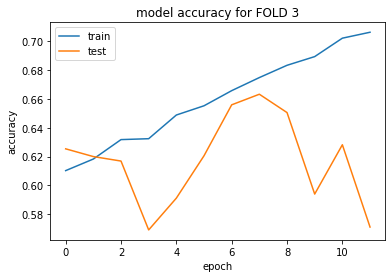


FOLD: 4
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [10602 10603 10604 ... 14133 14134 14135]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 10s 318us/sample - loss: 0.8593 - accuracy: 0.7027 - val_loss: 0.7243 - val_accuracy: 0.7513
Epoch 2/12
31800/31800 [==============================] - 6s 179us/sample - loss: 0.8116 - accuracy: 0.7224 - val_loss: 0.9178 - val_accuracy: 0.6675
Epoch 3/12
31800/31800 [==============================] - 6s 178us/sample - loss: 0.7910 - accuracy: 0.7325 - val_loss: 0.8682 - val_accuracy: 0.6740
Epoch 4/12
31800/31800 [==============================] - 5s 170us/sample - loss: 0.7589 - accuracy: 0.7369 - val_loss: 0.7960 - val_accuracy: 0.7085
Epoch 5/12
31800/31800 [==============================] - 6s 177us/sample - loss: 0.7698 - accuracy: 0.7343 - val_loss: 0.8224 - val_accuracy: 0.6986
Epoch 6/12
31800/31800 [==============================] - 6s 178us/sample - loss: 0.7266 - acc

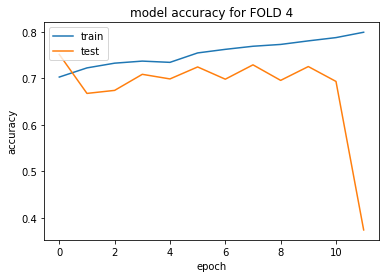


FOLD: 5
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [14136 14137 14138 ... 17667 17668 17669]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 10s 328us/sample - loss: 0.6470 - accuracy: 0.7912 - val_loss: 0.5970 - val_accuracy: 0.7920
Epoch 2/12
31800/31800 [==============================] - 6s 174us/sample - loss: 0.6218 - accuracy: 0.7958 - val_loss: 0.4772 - val_accuracy: 0.8325
Epoch 3/12
31800/31800 [==============================] - 5s 172us/sample - loss: 0.5971 - accuracy: 0.8071 - val_loss: 0.9333 - val_accuracy: 0.6868
Epoch 4/12
31800/31800 [==============================] - 6s 174us/sample - loss: 0.5765 - accuracy: 0.8131 - val_loss: 0.5288 - val_accuracy: 0.8195
Epoch 5/12
31800/31800 [==============================] - 5s 168us/sample - loss: 0.5660 - accuracy: 0.8181 - val_loss: 0.4975 - val_accuracy: 0.8336
Epoch 6/12
31800/31800 [==============================] - 5s 171us/sample - loss: 0.5403 - acc

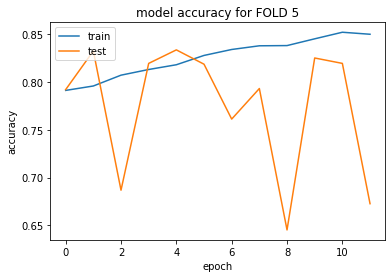


FOLD: 6
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [17670 17671 17672 ... 21201 21202 21203]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 11s 341us/sample - loss: 0.4955 - accuracy: 0.8442 - val_loss: 0.3580 - val_accuracy: 0.8930
Epoch 2/12
31800/31800 [==============================] - 5s 168us/sample - loss: 0.4675 - accuracy: 0.8532 - val_loss: 0.4642 - val_accuracy: 0.8452
Epoch 3/12
31800/31800 [==============================] - 5s 170us/sample - loss: 0.4562 - accuracy: 0.8556 - val_loss: 0.6488 - val_accuracy: 0.7963
Epoch 4/12
31800/31800 [==============================] - 5s 168us/sample - loss: 0.4170 - accuracy: 0.8697 - val_loss: 0.4499 - val_accuracy: 0.8495
Epoch 5/12
31800/31800 [==============================] - 5s 172us/sample - loss: 0.4026 - accuracy: 0.8749 - val_loss: 0.3283 - val_accuracy: 0.8913
Epoch 6/12
31800/31800 [==============================] - 5s 169us/sample - loss: 0.3949 - acc

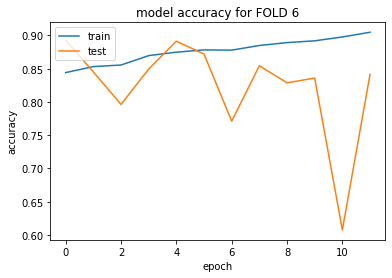


FOLD: 7
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [21204 21205 21206 ... 24735 24736 24737]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 10s 317us/sample - loss: 0.3738 - accuracy: 0.8875 - val_loss: 0.3711 - val_accuracy: 0.8772
Epoch 2/12
31800/31800 [==============================] - 5s 169us/sample - loss: 0.3469 - accuracy: 0.8976 - val_loss: 0.1687 - val_accuracy: 0.9519
Epoch 3/12
31800/31800 [==============================] - 5s 166us/sample - loss: 0.3283 - accuracy: 0.9018 - val_loss: 0.3853 - val_accuracy: 0.8738
Epoch 4/12
31800/31800 [==============================] - 5s 167us/sample - loss: 0.3071 - accuracy: 0.9080 - val_loss: 0.3579 - val_accuracy: 0.8896
Epoch 5/12
31800/31800 [==============================] - 5s 172us/sample - loss: 0.3202 - accuracy: 0.9023 - val_loss: 0.7703 - val_accuracy: 0.7671
Epoch 6/12
31800/31800 [==============================] - 5s 168us/sample - loss: 0.3046 - acc

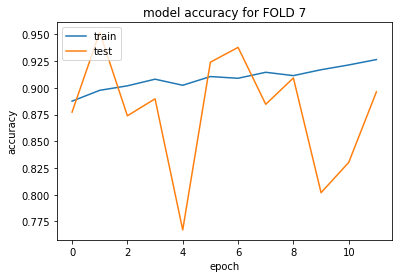


FOLD: 8
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [24738 24739 24740 ... 28269 28270 28271]
Train on 31800 samples, validate on 3534 samples
Epoch 1/12
31800/31800 [==============================] - 10s 315us/sample - loss: 0.2949 - accuracy: 0.9135 - val_loss: 0.2506 - val_accuracy: 0.9194
Epoch 2/12
31800/31800 [==============================] - 6s 174us/sample - loss: 0.2728 - accuracy: 0.9212 - val_loss: 0.3967 - val_accuracy: 0.8758
Epoch 3/12
31800/31800 [==============================] - 6s 175us/sample - loss: 0.2760 - accuracy: 0.9203 - val_loss: 0.2452 - val_accuracy: 0.9230
Epoch 4/12
31800/31800 [==============================] - 5s 170us/sample - loss: 0.2425 - accuracy: 0.9289 - val_loss: 0.2336 - val_accuracy: 0.9222
Epoch 5/12
31800/31800 [==============================] - 5s 172us/sample - loss: 0.2355 - accuracy: 0.9317 - val_loss: 0.3938 - val_accuracy: 0.8758
Epoch 6/12
31800/31800 [==============================] - 6s 182us/sample - loss: 0.2317 - acc

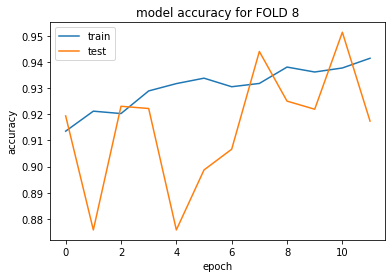


FOLD: 9
TRAIN: [    0     1     2 ... 35335 35336 35337] TEST: [28272 28273 28274 ... 31802 31803 31804]
Train on 31800 samples, validate on 3533 samples
Epoch 1/12
31800/31800 [==============================] - 11s 332us/sample - loss: 0.2371 - accuracy: 0.9321 - val_loss: 0.1828 - val_accuracy: 0.9454
Epoch 2/12
31800/31800 [==============================] - 6s 178us/sample - loss: 0.2256 - accuracy: 0.9364 - val_loss: 0.1138 - val_accuracy: 0.9621
Epoch 3/12
31800/31800 [==============================] - 6s 175us/sample - loss: 0.2124 - accuracy: 0.9391 - val_loss: 0.1168 - val_accuracy: 0.9694
Epoch 4/12
31800/31800 [==============================] - 6s 179us/sample - loss: 0.1996 - accuracy: 0.9409 - val_loss: 0.1036 - val_accuracy: 0.9740
Epoch 5/12
31800/31800 [==============================] - 6s 177us/sample - loss: 0.2003 - accuracy: 0.9414 - val_loss: 0.1523 - val_accuracy: 0.9587
Epoch 6/12
31800/31800 [==============================] - 5s 171us/sample - loss: 0.2045 - acc

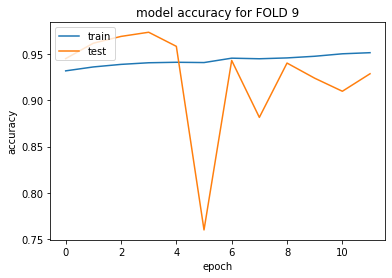


FOLD: 10
TRAIN: [    0     1     2 ... 31802 31803 31804] TEST: [31805 31806 31807 ... 35335 35336 35337]
Train on 31800 samples, validate on 3533 samples
Epoch 1/12
31800/31800 [==============================] - 11s 334us/sample - loss: 0.1805 - accuracy: 0.9479 - val_loss: 0.1085 - val_accuracy: 0.9703
Epoch 2/12
31800/31800 [==============================] - 5s 170us/sample - loss: 0.1856 - accuracy: 0.9465 - val_loss: 0.8265 - val_accuracy: 0.7373
Epoch 3/12
31800/31800 [==============================] - 6s 174us/sample - loss: 0.1748 - accuracy: 0.9504 - val_loss: 0.1254 - val_accuracy: 0.9621
Epoch 4/12
31800/31800 [==============================] - 5s 170us/sample - loss: 0.1825 - accuracy: 0.9476 - val_loss: 0.1253 - val_accuracy: 0.9638
Epoch 5/12
31800/31800 [==============================] - 5s 167us/sample - loss: 0.1744 - accuracy: 0.9502 - val_loss: 0.0857 - val_accuracy: 0.9796
Epoch 6/12
31800/31800 [==============================] - 5s 171us/sample - loss: 0.1668 - ac

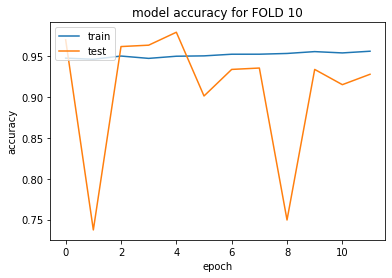

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(inp)
fold=1
batch_s=110
for train_index, test_index in kf.split(df):
    print("FOLD: "+str(fold))
    print("TRAIN:", train_index, "TEST:", test_index)
    inp_train_std, inp_test_std = inp_std[train_index], inp_std[test_index]
    out_train, out_test = out[train_index], out[test_index]
    
    if(len(inp_train_std)!=31800):
        inp_train_std=inp_train_std[:31800]
        out_train=out_train[:31800]
    
    
    history = model.fit(inp_train_std, out_train,
                        batch_size=120, 
                        #128 for previous methods without cross validation
                        epochs=12, 
                        validation_data=(inp_test_std, out_test), 
                        )
    
    
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for FOLD '+str(fold))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fold+=1
    print()

In [128]:
sample=test_samples[0:]

samp_pxls=np.array([np.fromstring(image, np.uint8, sep=" ").reshape((48, 48)) for image in sample.pixels])
samp_emot=sample.emotion.astype(np.int32).values
    
samp_pxls=samp_pxls/255.

#Saving Test Image
tmp_pxls=samp_pxls[5]
tmp_emot=samp_emot[5]
array = np.array(pxls, dtype=np.uint8)
from PIL import Image
img=Image.fromarray(array)
img.save('tmp.png')

In [130]:
samp_pxls = samp_pxls.reshape((-1, 48, 48, 1)).astype(np.float32)

(48, 48, 1)


In [64]:
preds=model.predict_classes(samp_pxls)
lbls=samp_emot

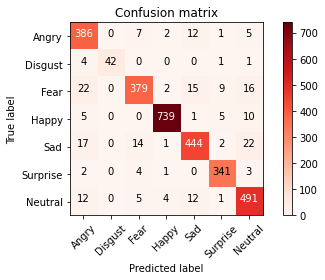

<Figure size 432x288 with 0 Axes>

In [84]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix as conf_mat
import itertools
import matplotlib.pyplot as plt
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'

cm=conf_mat(lbls, preds)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
